In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io
from scipy.stats import circvar, circmean, circstd

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace, pack_hdf
from scalebars import *
import deconv

import sac_mode_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
%matplotlib widget
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

In [4]:
data_path = os.path.join(base_path, "model_runs")
fig_path = os.path.join(base_path, "multiplex_rho_figs")
fig_subdir = None

# fig_subdir, exp_names = ("rho95_vs_rho95flat", {
#     "ctrl": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_9n_5tr_rho_range",
#     "flat": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95flat_er1p2_ir0p6_nr1p2_9n_5tr_rho_range",
# })
# fig_subdir, exp_names = ("fixed_rho95_vs_rho95flat", {
#     "ctrl": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_9n_5tr_fixrho_range",
#     "flat": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95flat_er1p2_ir0p6_nr1p2_9n_5tr_fixrho_range",
# })
fig_subdir, exp_names = ("fixed_rho95_vs_rho95flat", {
    "ctrl": "poissarma_etau4_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_9n_5tr_fixrho_range_resetrng",
    "flat": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95flat_er1p2_ir0p6_nr1p2_9n_5tr_fixrho_range",
})
# fig_subdir, exp_names = ("ctrl_vs_plex", {
#     "ctrl": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_9n_5tr_fixrho_range",
#     "plex4": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_9n_5tr_rho_range_corrplex4",
# })
# fig_subdir, exp_names = ("testrng", {
#     "ctrl": "poissarma_etau4_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_3n_3tr_testrng",
# })
# fig_subdir, exp_names = ("fixedrng", {
#     "ctrl": "poissarma_etau3_x0p45w_itau6_x0p8w_ntau6_x0p3_ar0p9_-0p1_rho95_er1p2_ir0p6_nr1p2_9n_5tr_fixrho_range_fixedrng",
# })

fig_path = fig_path if fig_subdir is None else os.path.join(fig_path, fig_subdir)
exp_hdfs = {k: h5.File(os.path.join(data_path, n) + ".h5", "r") for k, n in exp_names.items()}
d = {k: Workspace(hdf, read_only=True) for k, hdf in exp_hdfs.items()}
os.makedirs(fig_path, exist_ok=True)

exps = list(d.keys())
ctrl_lbl = exps[0]
expr_lbl = exps[-1]
# ctrl_lbl = "ctrl"
# expr_lbl = "plex3"
ctrl = d[ctrl_lbl]
expr = d[expr_lbl]

rhos = list(ctrl.keys())
idxs = sorted(ctrl[rhos[0]].keys())
print("==keys==")
print("exps:", exps)
print("rhos:", rhos)
print("idxs:", idxs)

==keys==
exps: ['ctrl', 'flat']
rhos: [0.0, 0.2, 0.4, 0.6, 0.8, 0.85, 0.9, 0.92, 0.94, 0.96, 0.98, 0.99, 1.0]
idxs: [0, 1, 2, 3, 4, 5, 6, 7, 8]


In [5]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            for wrk in d.values():
                wrk.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [6]:
params = d[ctrl_lbl][1.0][0]["params"]
xaxis = np.arange(int(params["tstop"] / params["dt"]) + 1) * params["dt"]
metrics = {exp: ana.get_sac_metrics(wrk) for exp, wrk in d.items()}

dir_labels = ctrl[rhos[0]][idxs[0]]["params"]["dir_labels"][:]
sac_thetas = {exp: ana.get_sac_thetas(wrk) for exp, wrk in d.items()}
sac_deltas = {exp: ana.get_sac_deltas(ts) for exp, ts in sac_thetas.items()} 
print("metrics:", list(metrics[ctrl_lbl][rhos[0]].keys()))

metrics: ['spikes', 'thetas', 'DSis', 'avg_theta', 'avg_DSi']


In [7]:
soma_vm = {
    exp: {
        rho: np.stack([d[exp][rho][net]["soma"]["Vm"] for net in idxs], axis=0)
        for rho in rhos
    } 
    for exp in exps
}

In [8]:
calc_rates = False
calc_rate_exn = ValueError("Cannot use rate_mode when rates have not been calculated (calc_rates = False)")
def assert_calc_rates(): 
    if not calc_rates: raise calc_rate_exn
if calc_rates:
    spike_rates = map_data(lambda vm: spike_transform(vm, 3000, 50), soma_vm)
    net_avg_spike_rates = map_data(lambda r: r.mean(axis=1), spike_rates)
    net_peak_spike_rates = map_data(lambda r: r.max(axis=-1), net_avg_spike_rates)

In [9]:
if calc_rates:
    st = np.mean(spike_rates[ctrl_lbl][1.0], axis=(0, 1)) 
    ex_rate_fig, ex_rate_ax = plt.subplots(1)
    ex_rate_ax_right = ex_rate_ax.twinx()
    ex_rate_ax.plot(xaxis, d[ctrl_lbl][1.0][0]["soma"]["Vm"][0, 3], c="black")
    ex_rate_ax_right.plot(xaxis, st[3] * 100)
    ex_rate_ax.set_ylabel("mV")
    ex_rate_ax_right.set_ylabel("Spike Rate (Hz)")
    ex_rate_ax.set_xlabel("Time (ms)")

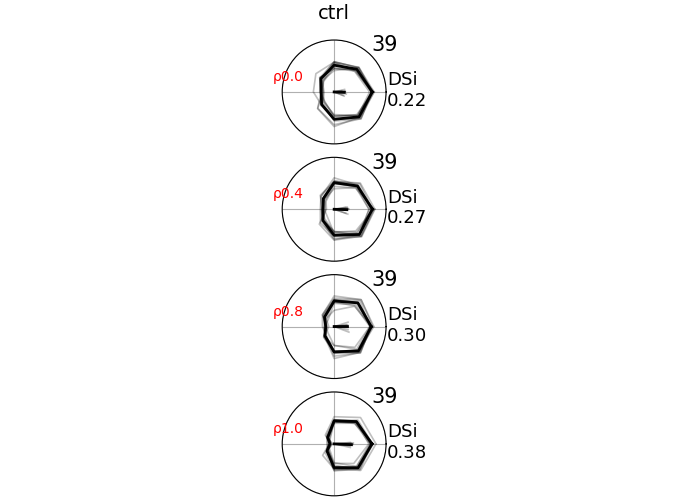

In [32]:
display_exps = exps
display_exps = ["ctrl"]
# display_rhos = rhos
# display_rhos = [1.0]
display_rhos = [0.0, 0.4, 0.8, 1.0]
rate_mode = False

if len(display_exps) <= 2:
    colours = ["black", "red"]
else:
    colours = ["C%i" % i for i in range(15)]

if rate_mode and assert_calc_rates():
    max_spikes = np.max([np.max(r) for ex in net_peak_spike_rates.values() for r in ex.values()])
else:
    max_spikes = np.max([r["spikes"] for ms in metrics.values() for r in ms.values()])
    
focus_polar_fig = plt.figure(figsize=(7, 5))
max_rows = 5
n_rows = min(max_rows, len(display_rhos))
splits = int(np.ceil(len(display_rhos) / max_rows))
n_cols = len(display_exps) * splits
focus_polar_ax = []
for i, rho in enumerate(display_rhos):
    row = i % max_rows
    subcol = i // max_rows
    for j, exp in enumerate(display_exps):
        focus_polar_ax.append(polar(
            (metrics[exp][rho]["spikes"]
             if not rate_mode 
             else net_peak_spike_rates[exp][rho].reshape(len(idxs), 1, 8)),
            dir_labels,
            title=None,
            radius=max_spikes,
            net_shadows=True,
            fig=focus_polar_fig,
            sub_loc=(n_rows, n_cols, (row * n_cols + j * splits + subcol + 1)),
            title_metrics=False,
            avg_colour=colours[j],
            shadow_alpha=0.25,
            shadow_linewidth=1.2,
        ))
        focus_polar_ax[-1].text(np.radians(170), max_spikes * 1.2, ("ρ" + str(rho)), c="red")

for i, exp in enumerate(display_exps):
    focus_polar_ax[i].set_title(exp, fontsize=14, pad=15)
    
exps_lbl = "_".join(display_exps)
rhos_lbl = "many_rhos" if len(display_rhos) > 4 else "_".join(map(str, display_rhos)).replace(".", "p")
focus_polar_fig.set_layout_engine("compressed")
for ext in [".png", ".svg"]:
    focus_polar_fig.savefig(
        os.path.join(fig_path, "%s_rhos%s_polars%s" % (exps_lbl, rhos_lbl, ext)), bbox_inches="tight")

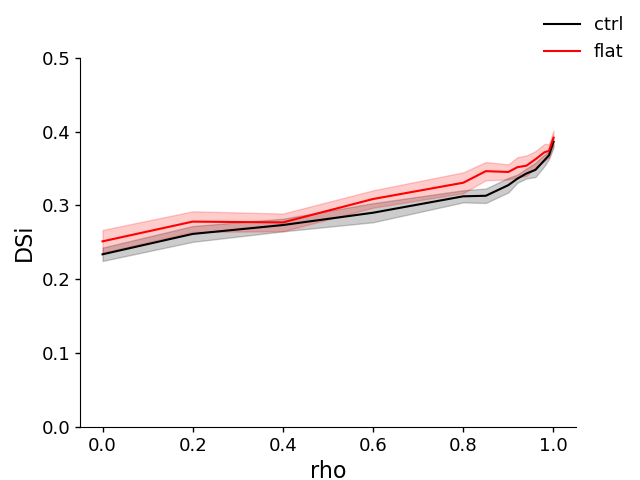

In [11]:
display_exps = exps
rate_mode = False
rho_colour_mode = False
sem_mode = True

if len(display_exps) <= 2:
    colours = ["black", "red"]
else:
    colours = ["C%i" % i for i in range(15)]


dsi_fig, dsi_ax = plt.subplots(1)
rho_range = {"dsi": {}, "theta": {}, "abstheta": {}, "thetavar": {}, "absnettheta": {}, "circvar": {}}
colour_idx = 0
n_sqrt = np.sqrt(len(idxs))
err_key = "sem" if sem_mode else "std"
for exp, clr in zip(exps, colours):
    for k in rho_range.keys():
        rho_range[k][exp] = {}
    for k in rho_range.keys():
        rho_range[k][exp] = {"nets": [], "avg": [], "std": [], "sem": []}
    rho_range["theta"][exp]["net_circvar"] = []
    rho_range["theta"][exp]["all_circvar"] = []
    for rho in rhos:
        net_mets = {}
        if rate_mode and assert_calc_rates():
            dsi_net_avgs, _ = calc_tuning(net_peak_spike_rates[exp][rho].T, dir_labels)
            net_mets["dsi"] = dsi_net_avgs
        else:
            net_mets["dsi"] = metrics[exp][rho]["DSis"].mean(axis=1)
        thetas = metrics[exp][rho]["thetas"]
        net_mets["theta"] = scale_180_from_360(np.degrees(circmean(np.radians(thetas), axis=1)))
        net_mets["abstheta"] = np.abs(thetas).mean(axis=1)
        net_mets["thetavar"] = np.var(thetas, axis=1)
        net_mets["absnettheta"] = np.abs(net_mets["theta"])
        net_mets["circvar"] = circvar(np.radians(thetas), axis=1)
        for (k, ns) in net_mets.items():
            rho_range[k][exp]["nets"].append(ns)
            if k == "theta":
                rho_range[k][exp]["avg"].append(
                    scale_180_from_360(np.degrees(circmean(np.radians(ns)))))
                rho_range[k][exp]["std"].append(
                    scale_180_from_360(np.degrees(circstd(np.radians(ns)))))
            else:
                rho_range[k][exp]["avg"].append(np.mean(ns))
                rho_range[k][exp]["std"].append(np.std(ns))
            rho_range[k][exp]["sem"].append(rho_range[k][exp]["std"][-1] / n_sqrt)
        rho_range["theta"][exp]["net_circvar"].append(circvar(np.radians(net_mets["theta"])))
        rho_range["theta"][exp]["all_circvar"].append(circvar(np.radians(thetas)))
    for k in rho_range.keys():
        rho_range[k][exp] = {m: np.array(v) for m, v in rho_range[k][exp].items()}
        rho_range[k][exp]["nets"] = rho_range[k][exp]["nets"].T
    if exp in display_exps:
        dsi_ax.fill_between(
            rhos, 
            rho_range["dsi"][exp]["avg"] + rho_range["dsi"][exp][err_key],
            rho_range["dsi"][exp]["avg"] - rho_range["dsi"][exp][err_key],
            color=clr,
            alpha=0.2,
        )
        dsi_ax.plot(
            rhos,
            rho_range["dsi"][exp]["avg"],
            color=clr,
            label="%s" % exp,
        )
        
rho_dsis = {exp: np.stack([ms[r]["DSis"] for r in rhos], axis=0) for exp, ms in metrics.items()}
rho_net_avg_dsis = {exp: np.mean(dsis, axis=2) for exp, dsis in rho_dsis.items()}
rho_net_std_dsis = {exp: np.std(avgs, axis=1) for exp, avgs in rho_net_avg_dsis.items()}
rho_spks = {
    exp: np.stack([ms[r]["spikes"].transpose(2, 0, 1) for r in rhos], axis=0)
    for exp, ms in metrics.items()
}
rho_net_avg_spks = {exp: np.mean(spks, axis=3) for exp, spks in rho_spks.items()}
rho_net_std_spks = {exp: np.std(avgs, axis=2) for exp, avgs in rho_net_avg_spks.items()}
rho_avg_dsis = {exp: np.array([np.mean(ms[r]["avg_DSi"]) for r in rhos]) for exp, ms in metrics.items()}
rho_avg_spks = {
    exp: np.stack([np.mean(ms[r]["spikes"], axis=(0, 1)) for r in rhos], axis=0)
    for exp, ms in metrics.items()
}
        
dsi_ax.set_ylabel("DSi", fontsize=16)
dsi_ax.set_xlabel("rho", fontsize=16)
# dsi_ax.set_xscale("log")
dsi_ax.set_ylim(0, 0.5)
# dsi_ax.set_yticks([0, 0.4, 0.8])

dsi_fig.legend(frameon=False, fontsize=13)
clean_axes(dsi_ax, ticksize=13)
exps_lbl = "_".join(display_exps)
rate_lbl = "_peakrate" if rate_mode else "" 
for ext in [".png", ".svg"]:
    dsi_fig.savefig(
        os.path.join(fig_path, "dsi_vs_rho_%s_%s%s" % (exps_lbl, rate_lbl, ext)),
        bbox_inches="tight",
    )

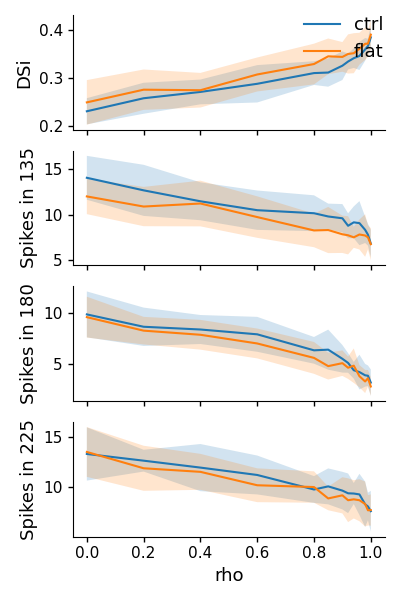

In [12]:
def rho_plot_dir(row, dir_idx):
    for exp in exps:
        rho_range_ax[row].fill_between(
            rhos,
            rho_avg_spks[exp][:, dir_idx] + rho_net_std_spks[exp][:, dir_idx],
            rho_avg_spks[exp][:, dir_idx] - rho_net_std_spks[exp][:, dir_idx],
            alpha=0.2,
        )
        rho_range_ax[row].plot(rhos, rho_avg_spks[exp][:, dir_idx])
        rho_range_ax[row].set_ylabel("Spikes in %i" % dir_labels[dir_idx], fontsize=13)
    
rho_range_fig, rho_range_ax = plt.subplots(4, sharex=True, figsize=(4, 6))
for exp in exps:
    rho_range_ax[0].fill_between(
        rhos,
        rho_avg_dsis[exp] + rho_net_std_dsis[exp],
        rho_avg_dsis[exp] - rho_net_std_dsis[exp],
        alpha=0.2,
    )
    rho_range_ax[0].plot(rhos, rho_avg_dsis[exp], label=exp)
    
rho_plot_dir(1, 6) # 135
rho_plot_dir(2, 7) # 180
rho_plot_dir(3, 0) # 225

rho_range_ax[0].set_ylabel("DSi", fontsize=13)
rho_range_ax[-1].set_xlabel("rho", fontsize=13)
rho_range_fig.legend(frameon=False, fontsize=13)
clean_axes(rho_range_ax)
rho_range_fig.tight_layout()

for ext in [".png", ".svg"]:
    rho_range_fig.savefig(os.path.join(fig_path, "dsi_spikes_rho_range" + ext), bbox_inches="tight")

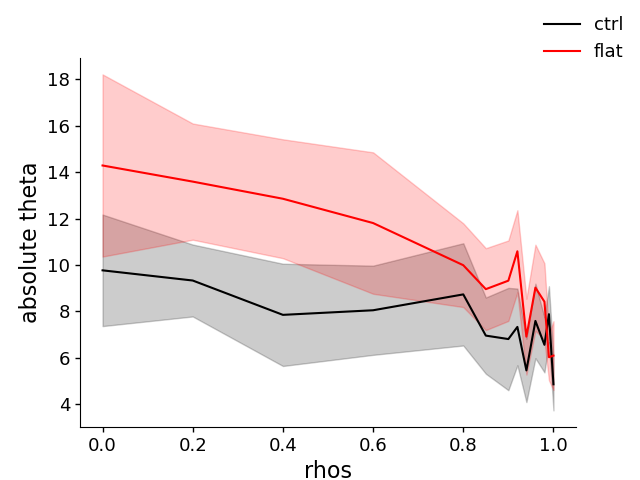

In [13]:
# abs_key = "abstheta" # absolute value of trial thetas then averaged by net
abs_key = "absnettheta"  # absolute value of signed net avgs
abstheta_fig, abstheta_ax = plt.subplots(1)
for exp, clr in zip(display_exps, colours):
    abstheta_ax.fill_between(
        rhos, 
        rho_range[abs_key][exp]["avg"] + rho_range[abs_key][exp][err_key],
        rho_range[abs_key][exp]["avg"] - rho_range[abs_key][exp][err_key],
        color=clr,
        alpha=0.2,
    )
    abstheta_ax.plot(
        rhos,
        rho_range[abs_key][exp]["avg"],
        color=clr,
        label=exp,
    )
        
abstheta_ax.set_ylabel("absolute theta", fontsize=16)
abstheta_ax.set_xlabel("rhos", fontsize=16)

abstheta_fig.legend(frameon=False, fontsize=13)
clean_axes(abstheta_ax, ticksize=13)

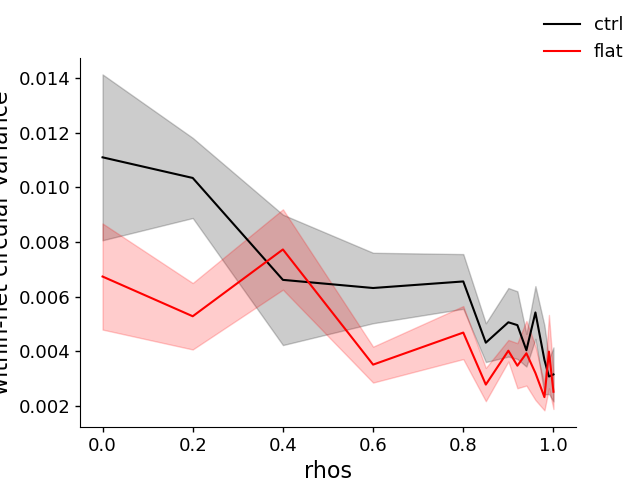

In [14]:
circvar_fig, circvar_ax = plt.subplots(1)
for exp, clr in zip(display_exps, colours):
    circvar_ax.fill_between(
        rhos, 
        rho_range["circvar"][exp]["avg"] + rho_range["circvar"][exp][err_key],
        rho_range["circvar"][exp]["avg"] - rho_range["circvar"][exp][err_key],
        color=clr,
        alpha=0.2,
    )
    circvar_ax.plot(
        rhos,
        rho_range["circvar"][exp]["avg"],
        color=clr,
        label=exp,
    )
        
circvar_ax.set_ylabel("within-net circular variance", fontsize=16)
circvar_ax.set_xlabel("rhos", fontsize=16)

circvar_fig.legend(frameon=False, fontsize=13)
clean_axes(circvar_ax, ticksize=13)

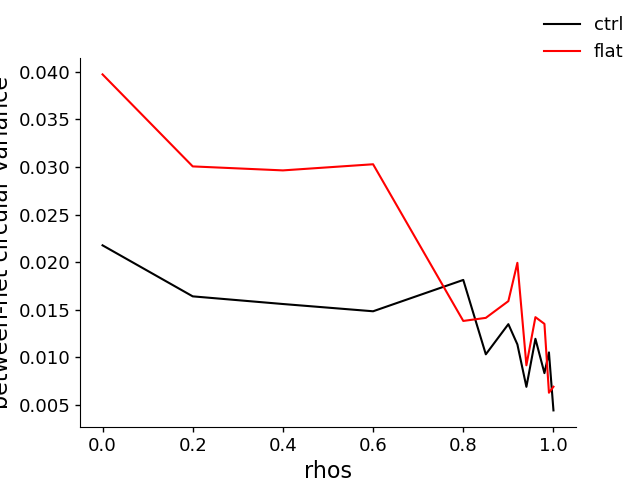

In [15]:
net_circvar_fig, net_circvar_ax = plt.subplots(1)
for exp, clr in zip(display_exps, colours):
    net_circvar_ax.plot(
        rhos,
        rho_range["theta"][exp]["net_circvar"],
        color=clr,
        label=exp,
    )
        
net_circvar_ax.set_ylabel("between-net circular variance", fontsize=16)
net_circvar_ax.set_xlabel("rhos", fontsize=16)

net_circvar_fig.legend(frameon=False, fontsize=13)
clean_axes(net_circvar_ax, ticksize=13)

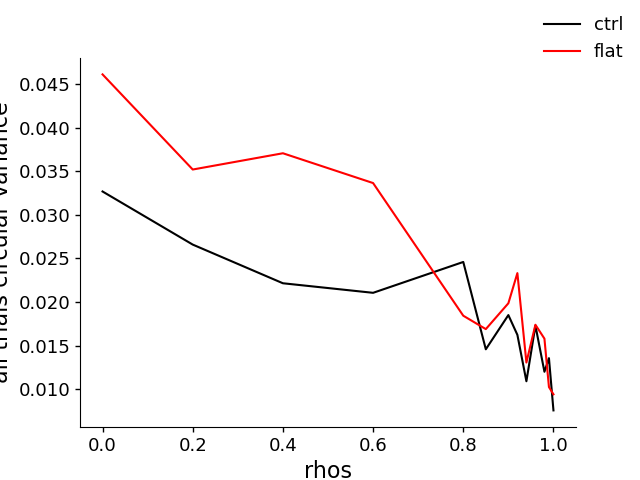

In [16]:
all_circvar_fig, all_circvar_ax = plt.subplots(1)
for exp, clr in zip(display_exps, colours):
    all_circvar_ax.plot(
        rhos,
        rho_range["theta"][exp]["all_circvar"],
        color=clr,
        label=exp,
    )
        
all_circvar_ax.set_ylabel("all trials circular variance", fontsize=16)
all_circvar_ax.set_xlabel("rhos", fontsize=16)

all_circvar_fig.legend(frameon=False, fontsize=13)
clean_axes(all_circvar_ax, ticksize=13)

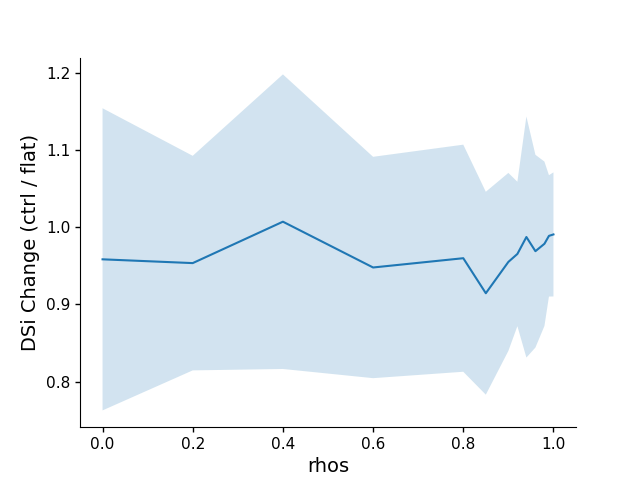

In [17]:
exp_dsi_effect_fig, exp_dsi_effect_ax = plt.subplots(1)
exp_dsi_effect_nets = rho_range["dsi"][ctrl_lbl]["nets"] / rho_range["dsi"][expr_lbl]["nets"] 
exp_dsi_effect_avg = np.mean(exp_dsi_effect_nets, axis=0)
exp_dsi_effect_std = np.std(exp_dsi_effect_nets, axis=0)

exp_dsi_effect_ax.fill_between(
    rhos, 
    exp_dsi_effect_avg + exp_dsi_effect_std,
    exp_dsi_effect_avg - exp_dsi_effect_std,
    alpha=0.2
)
exp_dsi_effect_ax.plot(rhos, exp_dsi_effect_avg)

exp_dsi_effect_ax.set_ylabel("DSi Change (%s / %s)" % (ctrl_lbl, expr_lbl), fontsize=14)
exp_dsi_effect_ax.set_xlabel("rhos", fontsize=14)
# exp_dsi_effect_ax.set_xscale("log")

clean_axes(exp_dsi_effect_ax)
exp_dsi_effect_fig.savefig(os.path.join(fig_path, "dsi_effect_of_exp.png"), bbox_inches="tight")

In [18]:
avg_dir_spikes = {
    exp: {rho: np.mean(nets["spikes"], axis=(0, 1)) for rho, nets in ms.items()}
    for exp, ms in metrics.items()
}
std_dir_spikes= {
    exp: {rho: np.std(nets["spikes"], axis=(0, 1)) for rho, nets in ms.items()}
    for exp, ms in metrics.items()
}

dirs_180 = np.array([ana.scale_180_from_360(d) for d in  dir_labels])
dir_sort = np.argsort(dirs_180)
dirs_sorted = dir_labels[dir_sort]
dirs_180_sorted = dirs_180[dir_sort]
if np.max(dirs_180) < 180:
    wrap_circ = lambda ds: np.r_[ds, ds[0]]
    circ_180 = np.r_[dirs_180_sorted, -dirs_180_sorted[0]]
else:
    wrap_circ = lambda ds: np.r_[ds[-1], ds] 
    circ_180 = np.r_[-dirs_180_sorted[-1], dirs_180_sorted] 

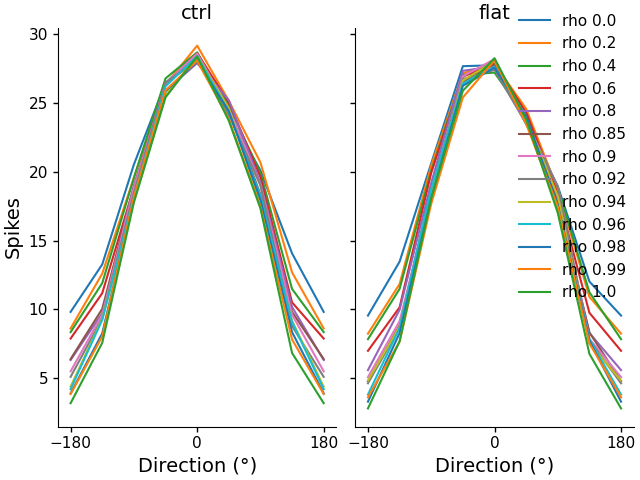

In [19]:
tuning_fig, tuning_ax = plt.subplots(1, len(metrics), sharey=True)
tuning_ax = [tuning_ax] if len(metrics) == 1 else tuning_ax
for i, (ax, exp) in enumerate(zip(tuning_ax, exps)):
    ax.set_xlabel("Direction (°)", fontsize=14)
    ax.set_title(exp, fontsize=14)
    for rho in rhos:
        lbl = ("rho " + str(rho)) if not i else None
        ax.plot(circ_180, wrap_circ(avg_dir_spikes[exp][rho][dir_sort]), label=lbl)
    ax.set_xticks([-180, 0, 180])
tuning_ax[0].set_ylabel("Spikes", fontsize=14)
tuning_fig.legend(frameon=False, fontsize=11)
clean_axes(tuning_ax)
tuning_fig.set_layout_engine("compressed")
tuning_fig.savefig(os.path.join(fig_path, "tuning.png"), bbox_inches="tight")

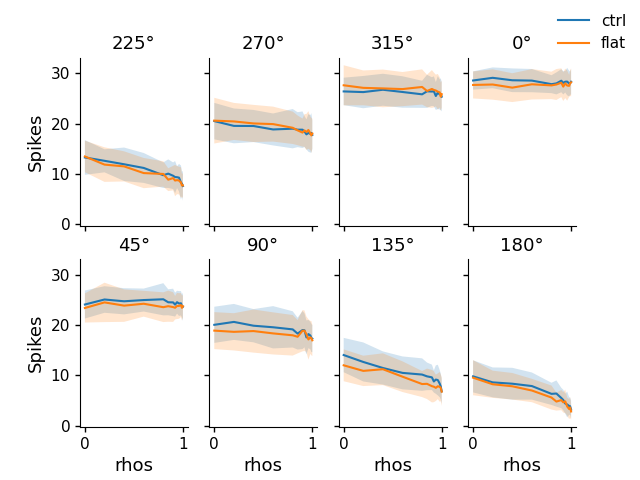

In [20]:
dir_grid_fig, dir_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

i = 0
for row in dir_grid_ax:
    row[0].set_ylabel("Spikes", fontsize=13)
    for ax in row:
        for exp in exps:
            spks = np.array([avg_dir_spikes[exp][rho][i] for rho in rhos])
            stds = np.array([std_dir_spikes[exp][rho][i] for rho in rhos])
            lbl = exp if not i else None
            ax.fill_between(rhos, spks + stds, spks - stds, alpha=0.2)
            ax.plot(rhos, spks, label=lbl)
            ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in dir_grid_ax.T:
    col[-1].set_xlabel("rhos", fontsize=13)

# dir_grid_ax[0, 0].invert_xaxis()
# dir_grid_ax[0, 0].set_xscale("log")
dir_grid_fig.legend(frameon=False, fontsize=11)
clean_axes(dir_grid_ax)
dir_grid_fig.savefig(os.path.join(fig_path, "dir_spikes_grid.png"), bbox_inches="tight")

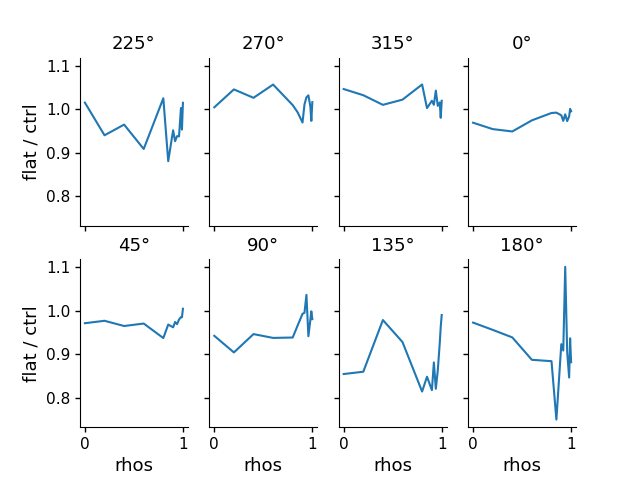

In [21]:
dir_exp_mult_grid_fig, dir_exp_mult_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

i = 0
for row in dir_exp_mult_grid_ax:
    row[0].set_ylabel("%s / %s" % (expr_lbl, ctrl_lbl), fontsize=13)
    for ax in row:
        ctrl_spks = np.array([avg_dir_spikes[ctrl_lbl][rho][i] for rho in rhos])
        expr_spks = np.array([avg_dir_spikes[expr_lbl][rho][i] for rho in rhos])
        ax.plot(rhos, expr_spks / ctrl_spks)
        ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in dir_exp_mult_grid_ax.T:
    col[-1].set_xlabel("rhos", fontsize=13)
        
clean_axes(dir_exp_mult_grid_ax)
dir_exp_mult_grid_fig.savefig(os.path.join(fig_path, "dir_spikes_effect_of_exp_grid.png"), bbox_inches="tight")

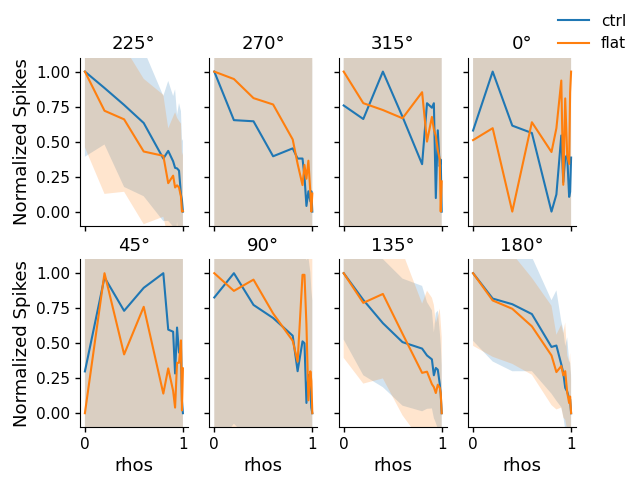

In [22]:
norm_dir_grid_fig, norm_dir_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

norm_dir_spikes, norm_dir_stds = {}, {}
for exp in exps:
    norm_dir_spikes[exp] = []
    norm_dir_stds[exp] = []
    for i in range(len(dir_labels)):
        spks = np.array([avg_dir_spikes[exp][rho][i] for rho in rhos])
        stds = np.array([std_dir_spikes[exp][rho][i] for rho in rhos])
        min_spks = np.min(spks)
        max_spks = np.max(spks)
        spks = (spks - min_spks) / (max_spks - min_spks)
        stds = stds / (max_spks - min_spks)
        norm_dir_spikes[exp].append(spks)
        norm_dir_stds[exp].append(stds)
norm_dir_spikes = {exp: np.stack(spks, axis=0) for exp, spks in norm_dir_spikes.items()}
norm_dir_stds = {exp: np.stack(stds, axis=0) for exp, stds in norm_dir_stds.items()}

i = 0
for row in norm_dir_grid_ax:
    row[0].set_ylabel("Normalized Spikes", fontsize=13)
    for ax in row:
        for exp in exps:
            lbl = exp if not i else None
            spks = norm_dir_spikes[exp][i]
            stds = norm_dir_stds[exp][i]
            ax.fill_between(rhos, spks + stds, spks - stds, alpha=0.2)
            ax.plot(rhos, spks, label=lbl)
            ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in norm_dir_grid_ax.T:
    col[-1].set_xlabel("rhos", fontsize=13)
        
norm_dir_grid_ax[0, 0].set_ylim(-0.1, 1.1)
norm_dir_grid_fig.legend(frameon=False, fontsize=11)
clean_axes(norm_dir_grid_ax)
norm_dir_grid_fig.savefig(os.path.join(fig_path, "norm_dir_spikes_grid.png"), bbox_inches="tight")

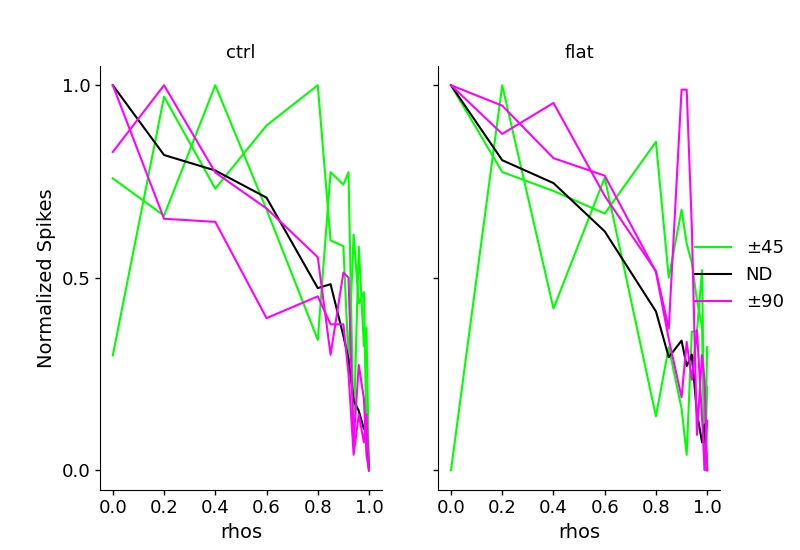

In [23]:
norm_rhos_null_fig, norm_rhos_null_ax = plt.subplots(1, len(exps), sharex=True, sharey=True, figsize=(8, 5.5))
norm_rhos_null_ax = [norm_rhos_null_ax] if len(metrics) == 1 else norm_rhos_null_ax
for i, (exp, ax) in enumerate(zip(exps, norm_rhos_null_ax)):
    ax.plot(rhos, norm_dir_spikes[exp][2], label="±45" if i else None, c="lime")  # 45
    ax.plot(rhos, norm_dir_spikes[exp][4], c="lime")  # 315
    ax.plot(rhos, norm_dir_spikes[exp][7], label="ND" if i else None, c="black")  # 180
    ax.plot(rhos, norm_dir_spikes[exp][1], label="±90" if i else None, c="magenta")  # 270
    ax.plot(rhos, norm_dir_spikes[exp][5], c="magenta")  # 90
    ax.set_title(exp, fontsize=13)
    ax.set_xlabel("rhos", fontsize=14)

norm_rhos_null_ax[0].set_yticks([0, 0.5, 1.0])
norm_rhos_null_ax[0].set_ylabel("Normalized Spikes", fontsize=14)
norm_rhos_null_fig.legend(frameon=False, loc="right", fontsize=13)
clean_axes(norm_rhos_null_ax, ticksize=13)
norm_rhos_null_fig.savefig(os.path.join(fig_path, "norm_null_spikes.png"), bbox_inches="tight")

In [24]:
avg_dir_spike_mats = {
    exp: np.stack(
        [wrap_circ(avg_dir_spikes[exp][rho][dir_sort]) for rho in rhos], axis=0
    )
    for exp in exps
}
avg_dir_max_spikes = np.max([m.max() for m in avg_dir_spike_mats.values()])

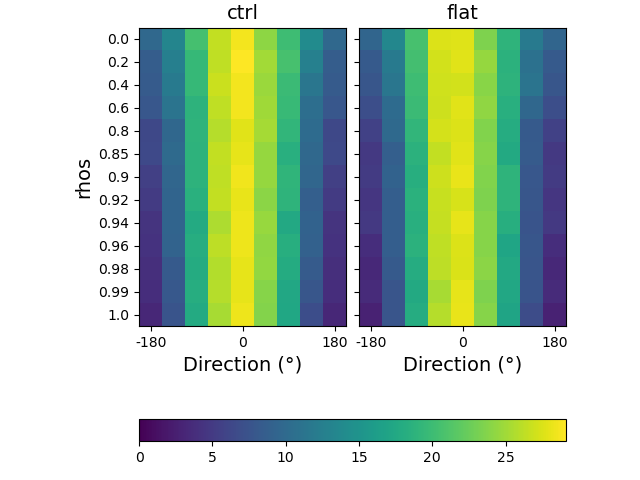

In [25]:
rho = 1.0
vmax = avg_dir_max_spikes
# vmax = 20.0

tuning_mat_fig, tuning_mat_ax = plt.subplots(1, len(exps), sharey=True)
tuning_mat_ax = [tuning_mat_ax] if len(metrics) == 1 else tuning_mat_ax
avg_spike_imgs = {}
for i, (ax, exp) in enumerate(zip(tuning_mat_ax, exps)):
    ax.set_xlabel("Direction (°)", fontsize=14)
    ax.set_title(exp, fontsize=14)
    avg_spike_imgs[exp] = ax.imshow(avg_dir_spike_mats[exp], vmin=0, vmax=vmax, cmap="viridis")
    ax.set_xticks([0, 4, 8])
    ax.set_xticklabels([-180, 0, 180])
    ax.set_yticks(range(len(rhos)))
    ax.set_yticklabels(rhos)
    
tuning_mat_ax[0].set_ylabel("rhos", fontsize=14)
tuning_mat_fig.colorbar(
    avg_spike_imgs[exps[-1]], ax=tuning_mat_ax, orientation="horizontal")
tuning_mat_fig.set_layout_engine("compressed")
tuning_mat_fig.savefig(os.path.join(fig_path, "tuning_matrices.png"), bbox_inches="tight")

In [26]:
pack_hdf(
    os.path.join(fig_path, "analysis"),
    {
        "rhos": rhos,
        "dir_labels": dir_labels,
        "dirs_180": dirs_180,
        "dir_sort": dir_sort,
        "dirs_sorted": dirs_sorted,
        "dirs_180_sorted": dirs_180_sorted,
        "circ_180": circ_180,
        "xaxis": xaxis,
        "sac_thetas": sac_thetas,
        "sac_deltas": sac_deltas,
        "metrics": metrics,
        "net_mets": net_mets,
        "rho_dsis": rho_dsis,
        "rho_net_avg_dsis": rho_net_avg_dsis,
        "rho_spks": rho_spks,
        "rho_net_avg_spks": rho_net_avg_spks,
        "rho_avg_dsis": rho_avg_dsis,
        "rho_avg_spks": rho_avg_spks,
        "avg_dir_spikes": avg_dir_spikes,
        "std_dir_spikes": std_dir_spikes,
    }
)

In [27]:
close_button()